## <font color="green"> TorchIntegral </font>: Definitions, Descriptions and Examples

---

<a name = 'content'></a>
<h1 align="center">Table of Contents

#### [Theory](#step1)
 * ##### [Structured and Unstructured Pruning](#step1.0)
 * ##### [INNs. Comparison with DNNs](#step1.1)
 * ##### [Integral Layers](#step1.2)
 * ##### [Smooth representation of weights tensors](#step1.3)
 * ##### [Paper results](#step1.4)

#### [Simple example](#step2)
 * ##### [Package installation](#step2.0)
 * ##### [ResNet single layer pruning](#step2.1)

<a name="step1"></a>

## Theory

[To the ToC](#content)

<a name="step1.0"></a>

#### Structured and Unstructured Pruning

[To the ToC](#content)

1. Unstructured pruning (Fine-grained (parameter) pruning)

* Removes parameters from the model
* Requires specialized hardware

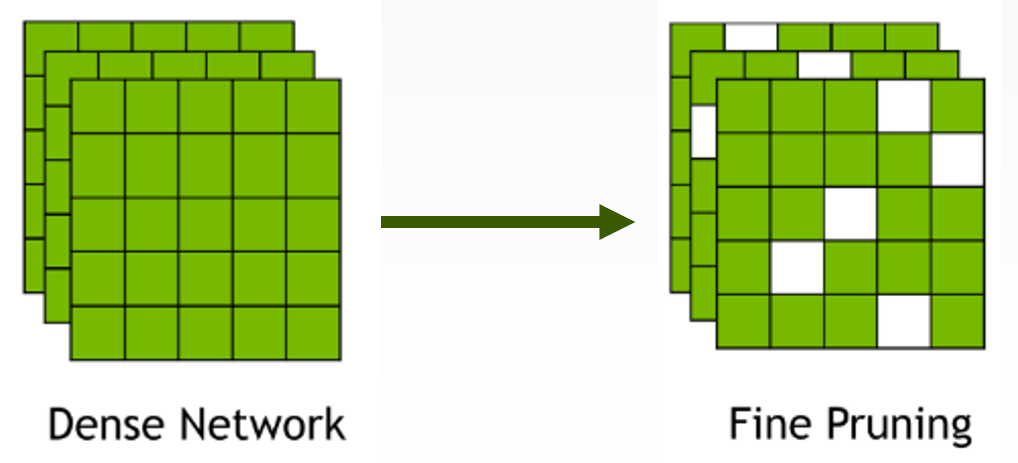


NVIDIA Ampere architecture Sparse Tensor Cores accelerate 2:4 fine-grained sparsity

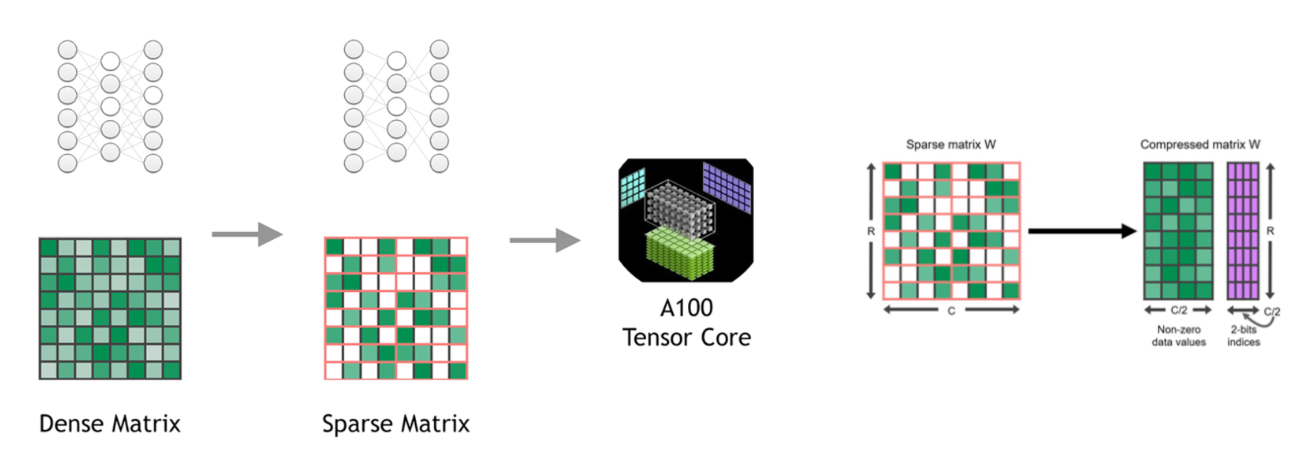

2. Structured pruning (Coarse-grained (channel) pruning)
* Removes feature maps from the model
* Common GPUs can take advantage of acceleration

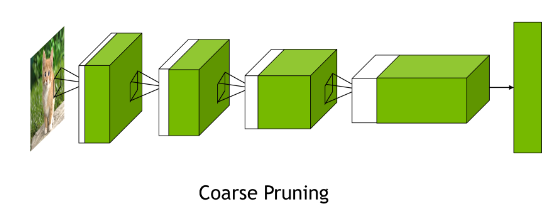

Industrial models always tend to be pruned in the structured manner since it does not require additional changes to the hardware and low-level software. But such kind of pruning demands accurate handling of dependencies because when we prune the input channels (let's say we are talking about convolutional layers) then we need to prune the output of all connected layers.

* Layers connected to the element-wise operations
need to be aligned in pruning
* Group channels with same channel index to
enforce pruning together

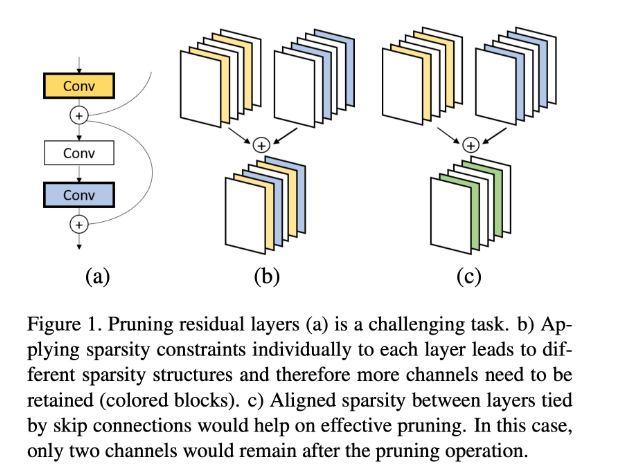

The most popular pipeline of pruning contains the following step:

0. Obtaine the trained applicable network;
1. Estimate importance of neurons (heads/channels for multi-head self-attention and convolutional layers correspondingly);
2. Rank neurons taking into account the calculated importances;
3. Remove least $K$ important units;
4. Finetune the pruned network;
5. Repeat steps 1-4 until you satisfy the trade-off between accuracy drop and speed-up.

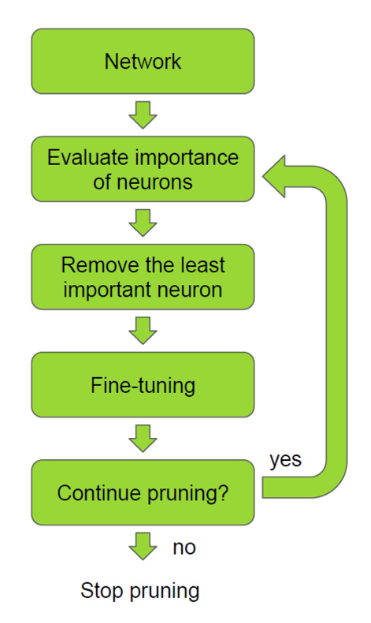

Importance estimation:
Globally, we can estimate the importance of each parameter in neural network computing the difference of the loss functions before and after removing the parameter, for example in the following way:

$$\mathcal{I}(w) = \big(E\left(\mathcal{D}, \mathbf{W}\right) - E\left(\mathcal{D}, \mathbf{W}| w=0\right)\big)^2$$

But this method requires to pass input through the $N$ neural networks (where $N$ -- is the total number of parameters), one for each removed parameter. For example, in Taylor Importance scoring we can avoid evaluating $N$ different networks by approximating $I(w)$ in the vicinity of $\bf{W}$ by its second-order Taylor
expansion.

$$\mathcal{I}^{(2)}(w, \mathbf{W}) = \bigg(g_w w - \dfrac{1}{2}w\mathbf{H}_w\mathbf{W} \bigg)$$

where $g_w = \dfrac{\partial E}{\partial w}$ are the elements of the gradient $\mathbf{g}$, $H_{i, j} = \dfrac{∂^2 E}{∂w_i ∂w_j}$ are elements of the Hessian $\mathbf{H}$ and $\mathbf{H}_w$ is its row correspond to the the weight $w$. An even more compact approximation is computed via the first-order expansion, which simplifies to:

$$\mathcal{I}^{(1)}(w, \mathbf{W}) = \bigg(g_w, w\bigg)^2$$

To estimate the importance of set of weights (the related group, or merely the convolutional filter) we can average the importance of all weights in the corresponding set.

$$\mathcal{I}^{(1)}(\mathcal{S}, \mathbf{W}) = \sum\limits_{w_s \in \mathcal{s}} (g_{w_s} w_s)^2$$

With the existence of BatchNormalization layer, the importance can be captured on BN layer:

$$\mathcal{I}^{(1)} (\gamma, \beta) = \bigg(\gamma \dfrac{∂E}{\partial γ} + \beta \dfrac{∂E}{∂β}\bigg) $$

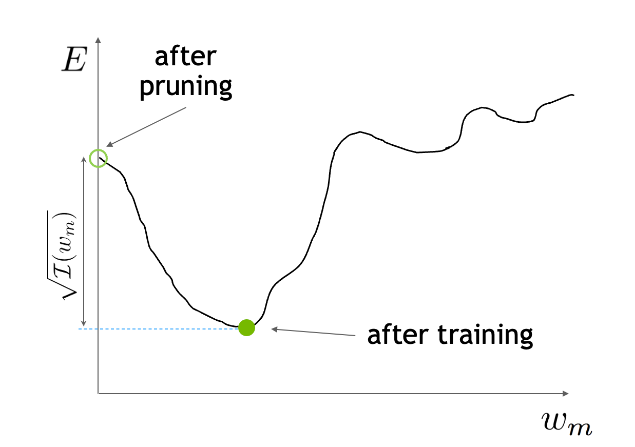

But even with the ideal estimation of weights the perfomance of the network after pruning cannot be the same as before and it does need the finetuning. The pruning without finetuning or with small finetuning was the main inspiration for the authors of the article about the integral neural networks.

<a name="step1.1"></a>

### INNs. Comparison with DNNs

[To the ToC](#content)

Integral Neural networks is a new class of neural networks that utilizes integral operators instead of linear operators that are parameterized by matrices. Let's first compare integral networks to discrete networks to understand exactly what the paper is suggesting. We know that the basic blocks of layers of classical neural networks are
linear or convolutional, that is, they essentially implement linear operators in a vector space defined by matrices or tensors. We cannot change the size after we've trained such a network. What happens in integral networks? Here we deal actually with parameters, which are represented by a matrix, but with functions of several variables. Specifically, the paper deals with smooth functions. We may note that we can consider an $n$-dimensional tensor as the values of a smooth function defined on the Cartesian square $ℝ^n× ℝ^n$ of real values.
And if we now take some points in $ℝ$ from where we have a mapping and calculate the values of this function, we will get just this $n$-dimensional tensor. Here we get the connection with classical neural networks. Here operators are replaced and act not as linear operators on vector spaces, but as functional operators, more specifically as integral operators. That is, linear operators on function spaces instead of linear operators on the space of finite-dimensional vectors. Parameters just define the kernel of a functional operator. Integral operators assume the existence of a locally integrable kernel. This is important for converting an integral model into a discrete model.

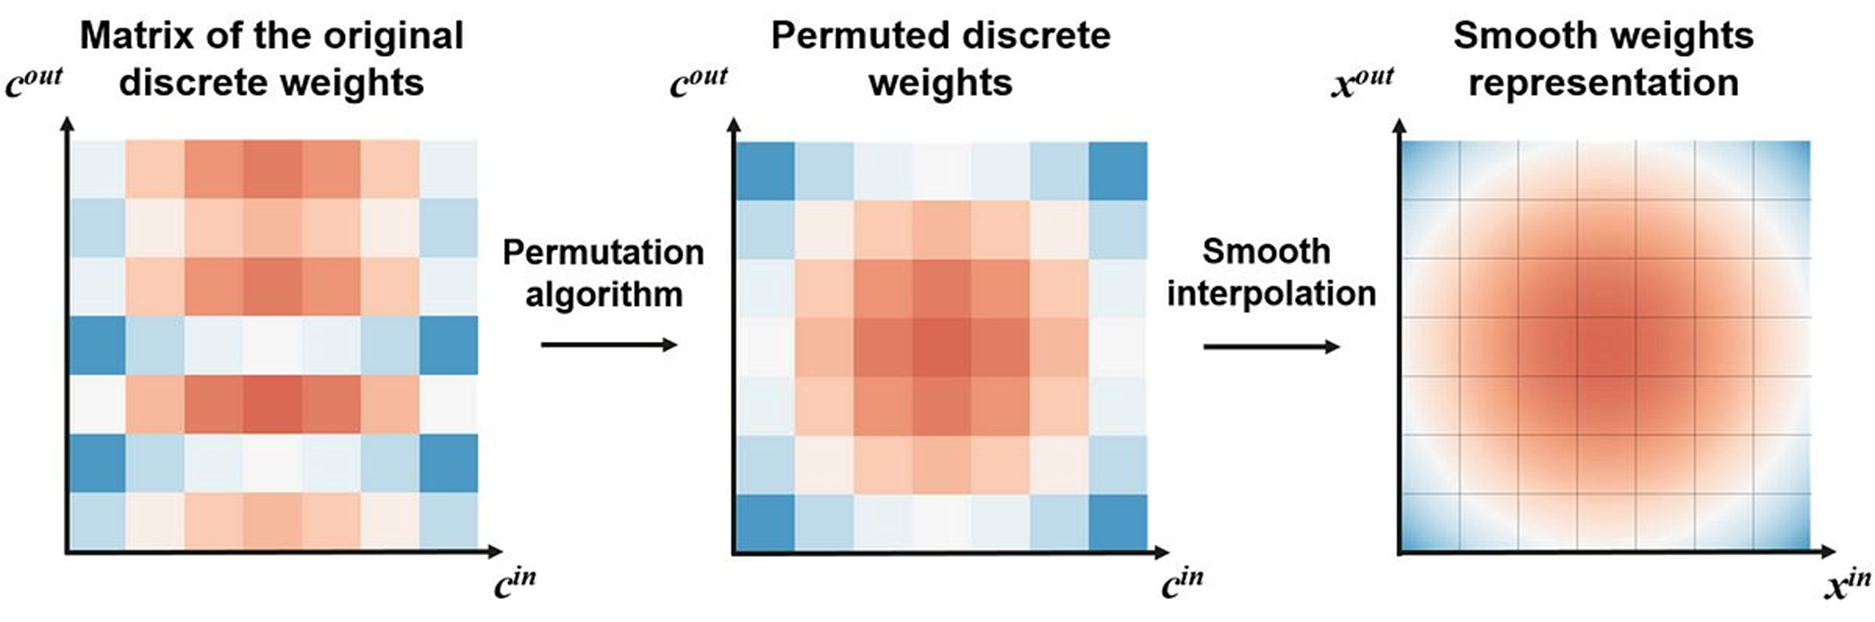

The property obtained from such a representation:

After training such a representation, each layer of the network computes an integral operator - think Riemann integral. The quality of the network now depends on the quality of the computation of the Riemann integral. Since the Riemann integral is closely related to the limits of the Riemann integral sums, from a certain point, at a certain number of points taken for integration, we will get already close to each other values. Hence the property of resampling that we can change the size of the network (channels, fiches, heads simply by changing the integration grid on inputs and on outputs), obtaining tensors of changed dimensionality.

<a name="step1.2"></a>

### Integral Layers

[To the ToC](#content)

Let's assume that we know how to set our parameters as a smooth representation. Then we have a goal to obtain such integral operators, which after discretization (numerical integration) or multiplication by quadrature will give the same result as ordinary linear operators. For the fully-connected layer operator, everything is simple:
$$
F_O(x^{out}) = \int\limits_0^1 F_W(\lambda, x^{out}, x^{in})F_I(x^{in})dx^{in}
$$
 This is $F_W$ is the parameter function, $F_I$ is the input function, $F_O$ is the output function. $x^{in}$, $x^{out}$ are the dimensions along which the discretization takes place (number of input channels, features, heads). That is, discretization by $x^{in}$, $x^{out}$ will give us $F_W$ as a matrix, $F_I$ and $F_O$ as vectors. The only difference is that the $F_W$ matrix must be multiplied by the quadrature matrix.

 Let us now consider convolution:
 $$F_O(x^{out}, \mathbf{x}^{\mathbf s}) \int\limits_\Omega F_W(\lambda, x^{out}, x^{in}, \mathbf{x^s}) F_I(x^{in}, \mathbf{x^s} + \mathbf{x^{s'}}) dx^{in}d\mathbf{x^s}$$
  You may ask why the integral here does not correspond to continuous convolution. It is explained by the fact that the continuous convolution formula does not take into account the summation in the dimensionality of filters (channels) in any way, so we add $x^{in}$ and $x^{out}$ additionally for sampling in the dimensionality of filters. The rest does not change.

You can see such a simple example of how FC layer works on the example of the picture below. We have as we have already said some kernel that defines parameters. It is set on the $x^{in}, x^{out}$ square. And this is some smooth function further we go to its discretization, namely fix some grid on this square. In the general case, we can consider the square $[0, 1]$, because if the function has limited support, we can map it there. Discretization by $c^{in}$ gives us the first dimension of the weights matrix, discretization by $c^{out}$ - the second. And then we simply multiply by the quadrature and get the usual discrete network, but reduced sized.

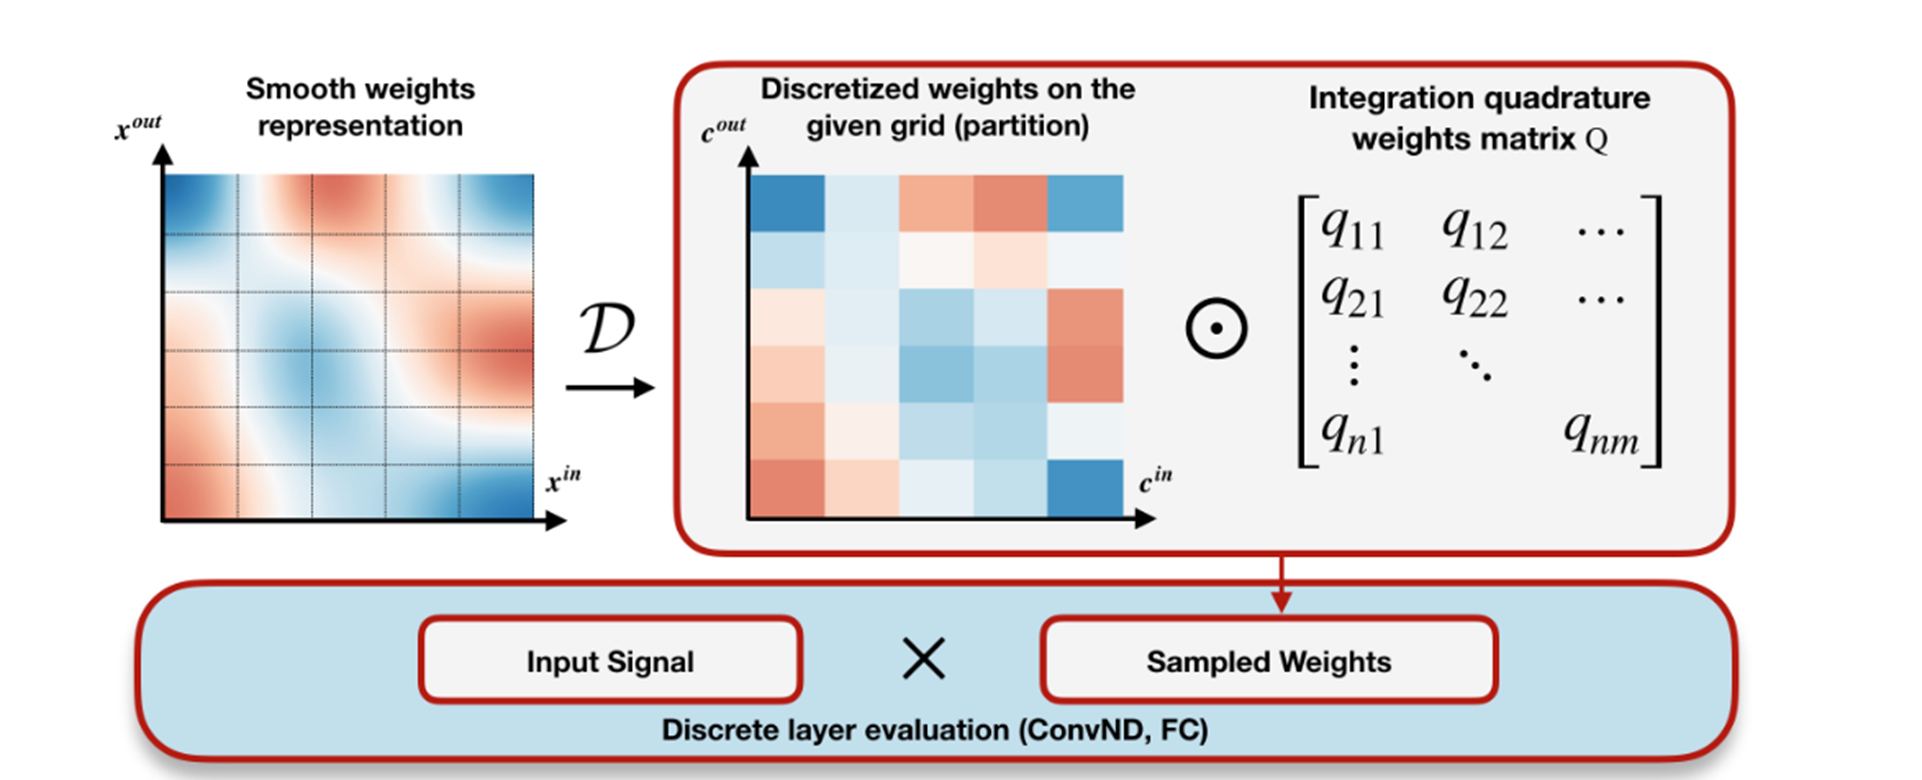

<a name="step1.3"></a>

### Smooth representation of weights

[To the ToC](#content)

Let's move on to how to set the parameters: the parameters are set quite simply, we can interpolate at each point of the grid with a cubic kernel. It will turn out to be almost cubic interpolation. However, the main reason why this interpolation is chosen is not because it is a simple interpolation method, but because its implementation is effective and is used everywhere, from image zoom to audio signal sampling. The approach is the same everywhere.
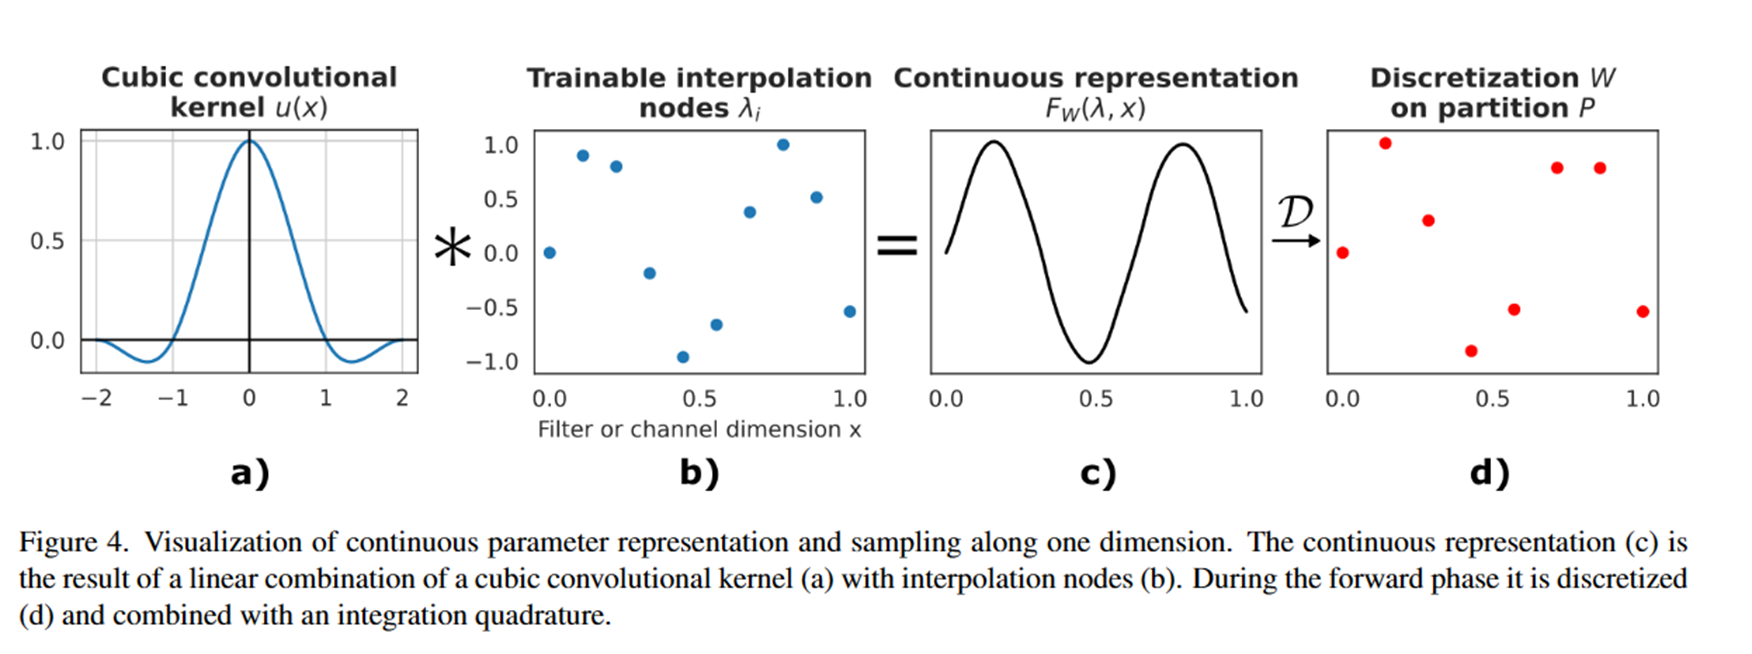

$$
F_W(\lambda, x) = \sum\limits_{i=0}^m \lambda_i u(xm - i)
$$

$$
W_q[k, l] = q_lW[k, l] = q_lF_W(\lambda, P_k^{out}, P_l^{in})
$$


The authors of the paper tried finetuning on a small dataset after pruning (like calibration in `PTQ`). If we teach the whole model after resampling and sampling, the results are a bit worse than if we teach only how to sample the weights. Also, learning the univariate sampling parameters is much faster than the whole model. Now, for example, we generally take some submodule of a large model, resample it and learn the grid only for it, ignoring most of the network. It works with variable success, but the results are better than those of classical pruning methods.

<a name="step1.4"></a>

### Paper results

[To the ToC](#content)

Feature maps of SRCNN 4x INN and DNN correspondingly.

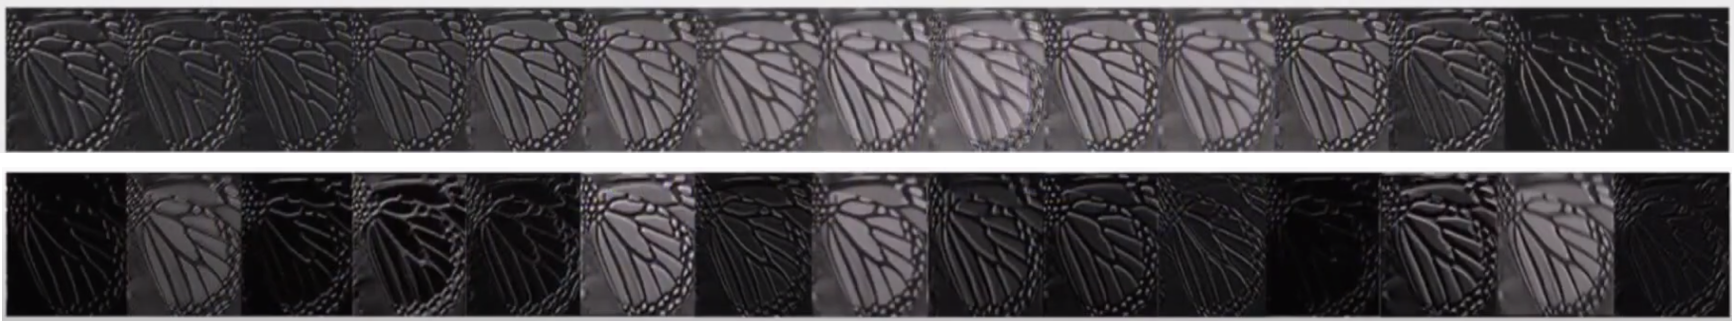

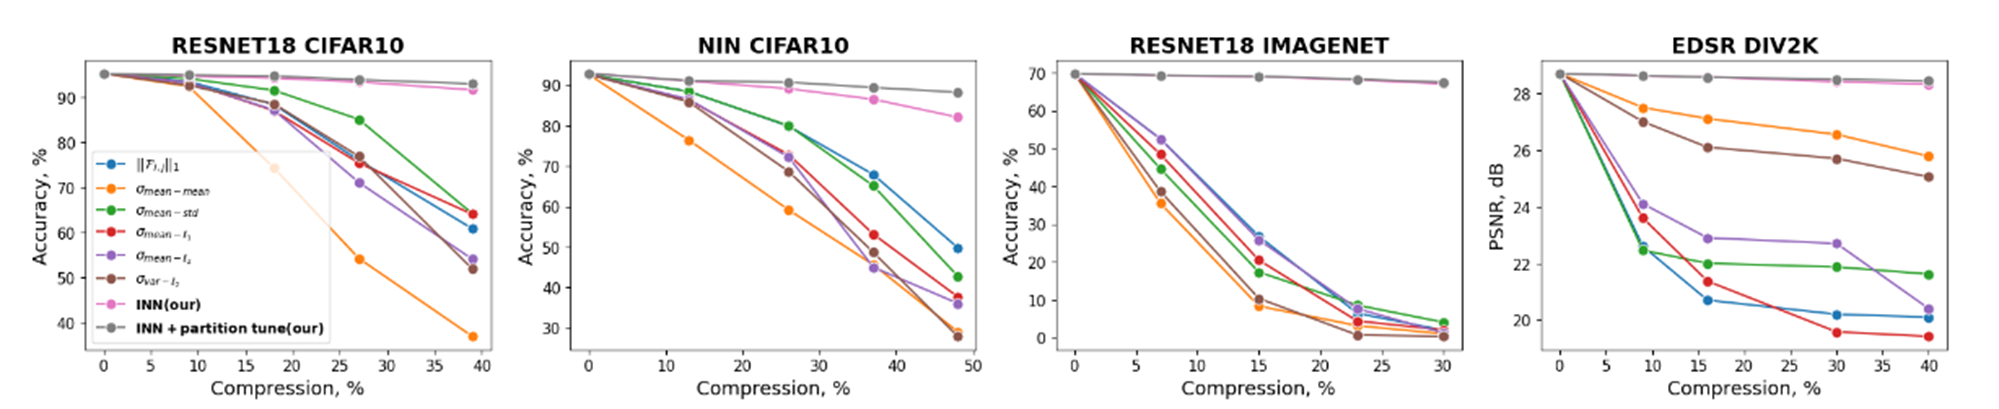

Let's now consider ImageNet dataset for the example.

<a name="step2"></a>

## Simple example

[To the ToC](#content)

<a name="step2.0"></a>

### Package installation

[To the ToC](#content)

In [ ]:
! git clone https://github.com/TheStageAI/TorchIntegral.git
! pip install TorchIntegral/
# ! pip install datasets

Cloning into 'TorchIntegral'...
remote: Enumerating objects: 1279, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 1279 (delta 57), reused 65 (delta 53), pack-reused 1050
Receiving objects: 100% (1279/1279), 783.45 KiB | 3.94 MiB/s, done.
Resolving deltas: 100% (769/769), done.
Processing ./TorchIntegral
  Preparing metadata (setup.py) ... done
  Created wheel for TorchIntegral: filename=TorchIntegral-0.0.0-cp310-cp310-linux_x86_64.whl size=388126 sha256=ad98ddf439dbbd9e4464551e775a15500a7b756e3b0382db6f8262e0071f4c8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0a0nvmc0/wheels/fc/1a/b6/3bdf0827b9a920013e913bdce57788e6d48da72d4965073b56
Successfully built TorchIntegral


In [ ]:
from torchvision.models import ResNet18_Weights, resnet18

<a name="step2.1"></a>

### ResNet single layer pruning

[To the ToC](#content)

In [ ]:
import torch_integral as inn
from copy import deepcopy


model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
original_model = deepcopy(model)
wrapper = inn.IntegralWrapper(
    init_from_discrete=True,
    # permutation_config={"iters": 10, "threshold": 0.1}
)

# Specify continuous dimensions which you want to prune
continuous_dims = {
    "layer4.0.conv1.weight": [0],
    "layer4.1.conv1.weight": [0, 1]
}

# Convert to integral model
inn_model = wrapper(model, (1, 3, 224, 224), continuous_dims)

# Set distribution for random number of integration points
inn_model.groups[0].reset_distribution(inn.UniformDistribution(8, 16))
inn_model.groups[1].reset_distribution(inn.UniformDistribution(16, 48))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.1MB/s]
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Rearranging of group 0
variation before permutation: 137.10707092285156
variation after permutation: 39.564151763916016
Rearranging of group 1
variation before permutation: 595.0445556640625
variation after permutation: 314.7388916015625
Rearranging of group 2
variation before permutation: 172.2285919189453
variation after permutation: 131.17208862304688
layer4.0.conv1.weight
loss before optimization:  2.0659519830556333e-14
layer4.0.conv1.bias
loss before optimization:  4.078171584069243e-14
layer4.0.conv2.weight
loss before optimization:  5.013142136654769e-13
layer4.0.downsample.0.weight
loss before optimization:  3.736517388899796e-13
layer4.0.downsample.0.bias
loss before optimization:  1.3064755440689302e-12
layer4.0.conv2.bias
loss before optimization:  1.0410911499211806e-12
layer4.1.conv1.weight
loss before optimization:  3.8179261320362215e-14
layer4.1.conv2.weight
loss before optimization:  9.002424673776321e-12
layer4.1.conv2.bias
loss before optimization:  2.66590720852943

In [ ]:
inn_model.groups[0].resize(12)
inn_model.groups[1].resize(16)

In [ ]:
discrete_model = inn_model.get_unparametrized_model()

In [ ]:
def get_module_by_name(module, name):
    for s in name.split("."):
        module = getattr(module, s)

    return module

def total_params(model, verbose=False):
    n_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"Total number of parameters: {n_params / 1_000_000:.2f}M")

    return n_params

In [ ]:
#let's compare the shapes
get_module_by_name(discrete_model, "layer4.0.conv1.weight").shape, get_module_by_name(original_model, "layer4.0.conv1.weight").shape

(torch.Size([10, 256, 3, 3]), torch.Size([512, 256, 3, 3]))

In [ ]:
before = total_params(original_model, verbose=True)
after = total_params(discrete_model, verbose=True)
print(f"ratio: {before / after}")

Total number of parameters: 11.69M
Total number of parameters: 3.76M
ratio: 3.1087407930625113


In [ ]:
# import torchvision.transforms as transforms
# import PIL
# import torchvision
# import torch
# import datasets
# from torch.utils.data import Dataset, DataLoader
# from rich.progress import track


# DATA_PATH = "./data"
# hf_dataset = datasets.load_dataset("zh-plus/tiny-imagenet", split='valid')

In [ ]:
# # let's exclude all non-RGB images
# excluded_idxs = [
#     i for i, sample in enumerate(hf_dataset) if sample['image'].mode != 'RGB'
# ]
# len(excluded_idxs)

In [ ]:
# # create new dataset exluding those idx
# hf_dataset = hf_dataset.select(
#     (
#         i for i in range(len(hf_dataset))
#         if i not in set(excluded_idxs)
#     )
# )

In [ ]:
# normalize = transforms.Normalize(
#     mean=[0.485, 0.456, 0.406],
#     std=[0.229, 0.224, 0.225]
# )
# input_transform = transforms.Compose([
#     transforms.Resize(256, PIL.Image.BICUBIC),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     normalize,
# ])

# def apply_transforms(sample):
#     sample['input'] = [input_transform(image) for image in sample["image"]]
#     return sample


# class CustomDataset(Dataset):
#     def __init__(self, hf_dataset, transform):
#         self.hf_dataset = hf_dataset
#         self.transform = transform
#         self.hf_dataset.set_transform(transform)


#     def __len__(self):
#         return len(self.hf_dataset)

#     def __getitem__(self, idx):
#         sample = self.hf_dataset[idx]
#         image = sample['input']
#         label = sample['label']
#         return image, label

# class CustomDataLoader(DataLoader):
#     def __init__(self, hf_dataset, transform, batch_size=32, shuffle=False, num_workers=2):
#         dataset = CustomDataset(hf_dataset, transform)
#         super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# dataloader = CustomDataLoader(hf_dataset, apply_transforms, batch_size=8)

In [ ]:
# correct = 0
# total = 0

# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for images, labels in dataloader:
#         # calculate outputs by running images through the network
#         outputs = model(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         print(correct)

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# import matplotlib.pyplot as plt
# from skimage.util import img_as_ubyte


# def plot_batch(batch):
#     fig, ax = plt.subplots(2, 4, figsize=(10, 5))
#     samples, labels = batch
#     for i, (sample, label) in enumerate(zip(samples, labels)):
#         ax[int(i//4)][int(i%4)].imshow(sample.permute(1, 2, 0).numpy())
#         ax[int(i//4)][int(i%4)].set_title(label.item())
#     plt.show()


# batch = next(iter(dataloader))
# plot_batch(batch)